In [1]:
from PIL import Image
import numpy as np

from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
from pymatting.alpha import estimate_alpha
from pymatting import blend,estimate_foreground

import cv2


import torch
from torchvision import transforms

# from utils import image_to_trimap 


In [167]:

def generate_trimap(probs, size, conf_threshold):
    # trimap = (probs > 0.05).astype(float) * 0.5

    pixels = 2 * size + 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (pixels, pixels))

    fg = (probs > conf_threshold).astype(float)
    unknown = np.logical_and(probs > 0.1, probs <= conf_threshold).astype(float) * 0.5

    

    fg = cv2.erode(fg, kernel, iterations=1)
    unknown = cv2.dilate(unknown, kernel, iterations=2)

    
    trimap = np.clip(fg + unknown,0,1)
    plt.imshow(trimap)
    plt.show()

    return trimap


def image_to_trimap(image, model, return_seg_mask=False):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

    batch: torch.Tensor = preprocess(image).unsqueeze(0)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    batch = batch.to(device)
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        output: torch.Tensor = model(batch)["out"][0].softmax(dim=0)

    fg_probs = (1.0 - output[0]).cpu().numpy()

    if return_seg_mask:
        predictions = output.argmax(0).cpu().numpy()
        seg_mask = np.vectorize(lambda pix: 0 if pix == 0 else 255)(predictions)[
            ..., np.newaxis
        ]
        return generate_trimap(fg_probs, 3, 0.9), seg_mask

    return generate_trimap(fg_probs, 3, 0.9)




In [156]:
model = deeplabv3_resnet101(pretrained=True)

images = [
    Image.open("images/cat_easy.jpg"),
    Image.open("images/cat_hard.jpg"),
    Image.open("images/persons.jpg"),
    Image.open("images/dog.jpg"),
    Image.open("images/dog_easy.jpg"),
]

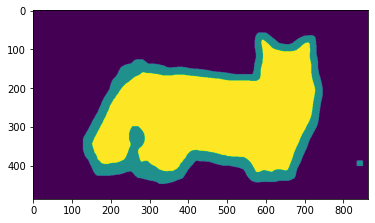

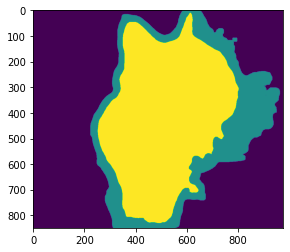

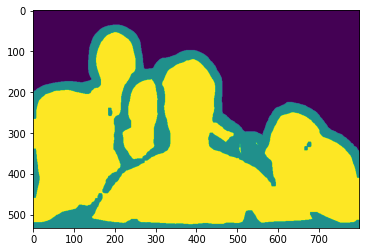

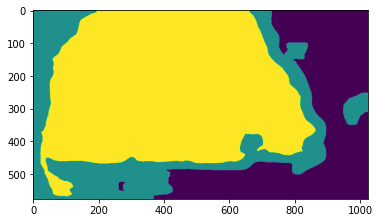

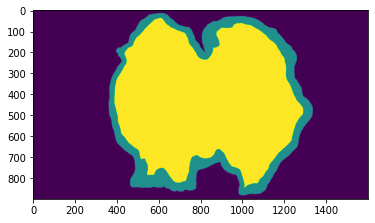

In [168]:
trimaps, seg_masks = map(list, zip(*[image_to_trimap(img,model,return_seg_mask=True) for img in images]))

trimaps = []

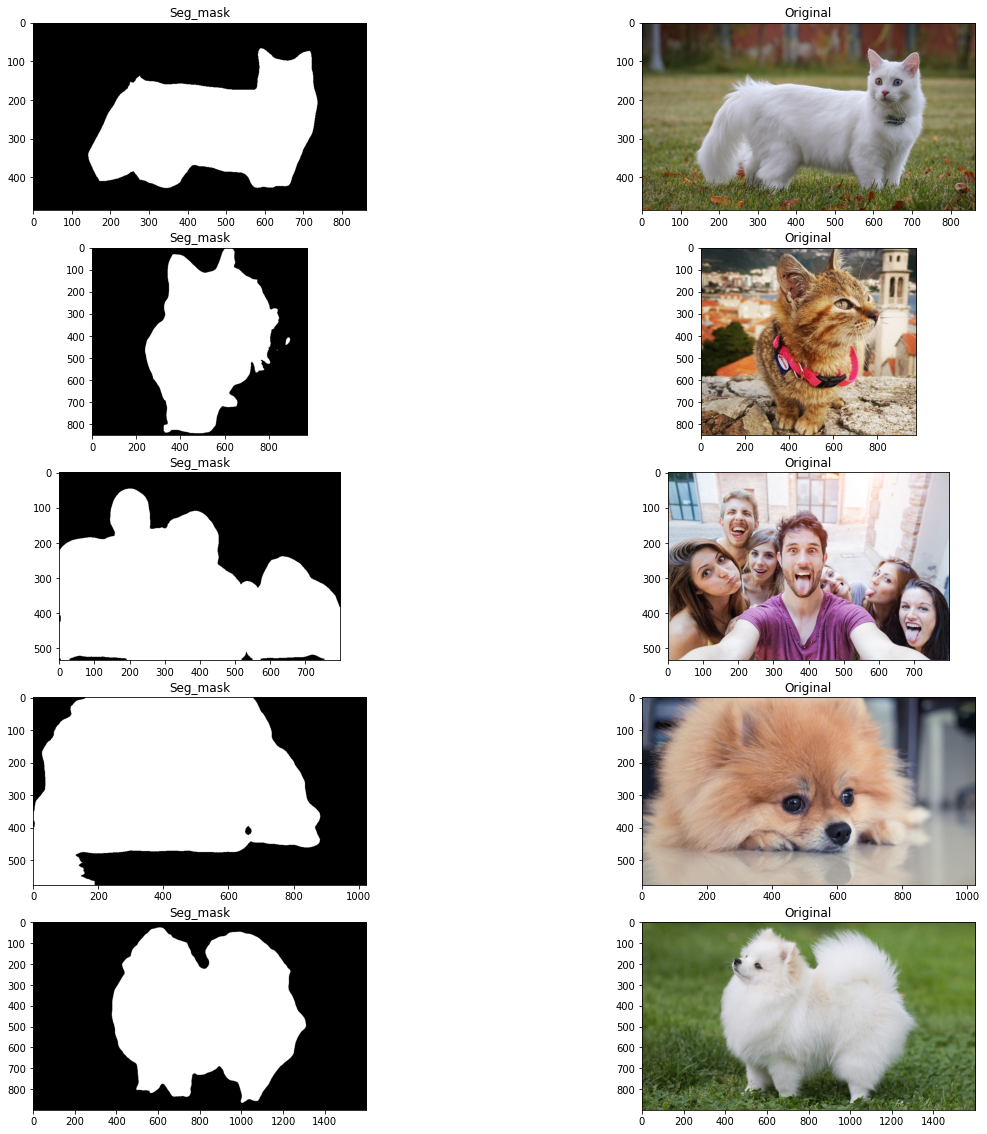

In [158]:

f, axarr = plt.subplots(len(seg_masks), 2, figsize=(25, 25))

for i, (seg_mask, img) in enumerate(zip(seg_masks, images)):
    axarr[i, 0].set_title("Seg_mask")
    axarr[i, 0].imshow(seg_mask, cmap="gray")
    axarr[i, 1].set_title("Original")
    axarr[i, 1].imshow(np.array(img))



PERFORMANCE WARNING:
Thresholded incomplete Cholesky decomposition failed due to insufficient positive-definiteness of matrix A with parameters:
    discard_threshold = 1.000000e-04
    shift = 0.000000e+00
Try decreasing discard_threshold or start with a larger shift

PERFORMANCE WARNING:
Thresholded incomplete Cholesky decomposition failed due to insufficient positive-definiteness of matrix A with parameters:
    discard_threshold = 1.000000e-04
    shift = 1.000000e-04
Try decreasing discard_threshold or start with a larger shift



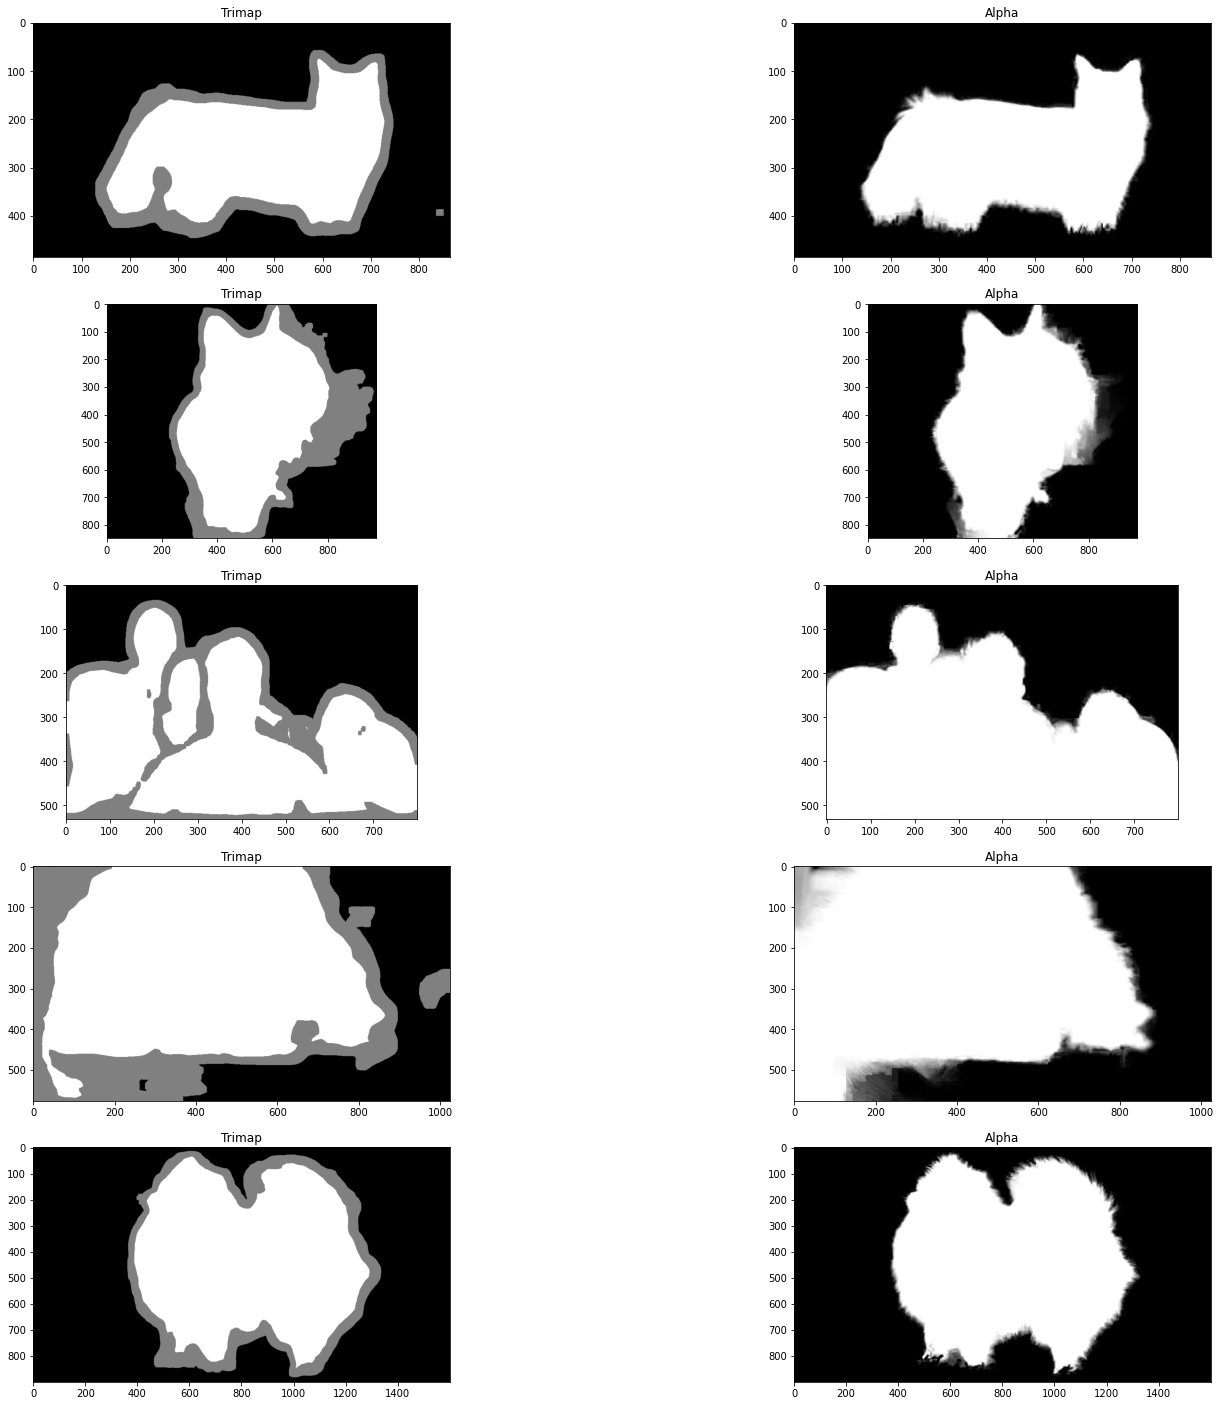

In [169]:

alphas = [estimate_alpha(
    np.array(img) / 255.0,
    trimap,
) for img,trimap in zip(images,trimaps)]



f, axarr = plt.subplots(len(trimaps),2, figsize=(25, 25))

for i, (alpha, trimap) in enumerate(zip(alphas, trimaps)):
    axarr[i, 0].set_title("Trimap")
    axarr[i, 0].imshow(trimap, cmap="gray")
    axarr[i, 1].set_title("Alpha")
    axarr[i, 1].imshow(alpha,cmap="gray")


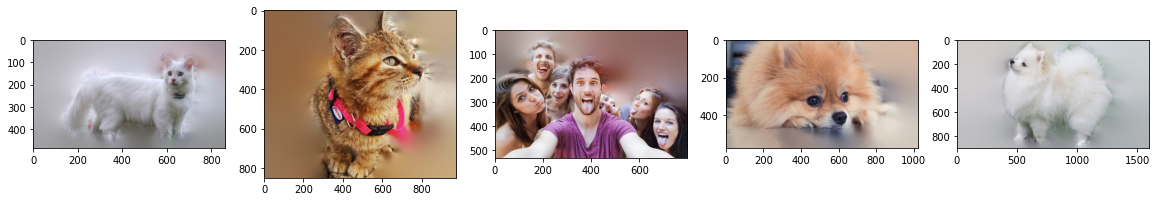

In [170]:

fgs = [estimate_foreground(np.array(img) / 255.0, alpha) for img, alpha in zip(images, alphas)]

f, axarr = plt.subplots(1,len(alphas),figsize=(20,20))

for im,fg in zip(axarr,fgs):
    im.imshow(fg)


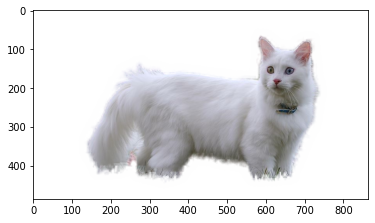

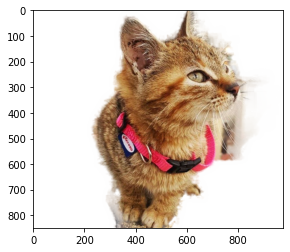

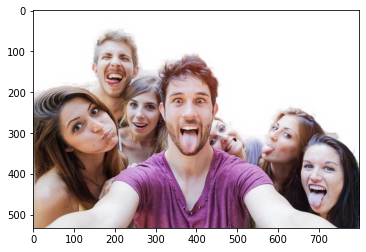

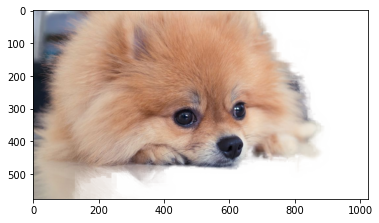

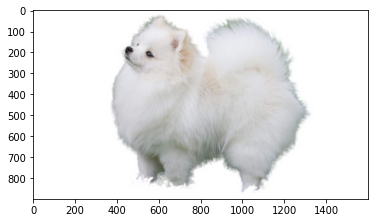

In [171]:
res = []
for fg, alpha in zip(fgs, alphas):

    bg = np.ones(fg.shape)

    res.append(blend(fg,bg,alpha))

for i,r in enumerate(res):
     plt.imshow(r)
     plt.show()
     r = np.clip(r * 255,0,255).astype(np.uint8)

    
     cv2.imwrite(f"results/{i}.png",cv2.cvtColor(r,cv2.COLOR_BGR2RGB))